In [ ]:
!pip install opencv-python -U

In [ ]:
!pip install gdown
!gdown --id 1IQ90jtnITrrcBWsFjF8jkFXF7LAxDqLF

In [ ]:
%%time
import zipfile
zip_ref = zipfile.ZipFile("archive.zip", 'r')
zip_ref.extractall("./scenery")
zip_ref.close()

CPU times: user 3.5 s, sys: 1.23 s, total: 4.73 s
Wall time: 5.43 s


In [ ]:
import matplotlib.pyplot as plt
def show_images(images, figsize=(20,10), columns = 5):
  plt.figure(figsize=figsize)
  for i, image in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.imshow(image)

In [ ]:
import os
IMAGE_PATH="./scenery"
file_names=os.listdir(IMAGE_PATH)
print(f"number of images: {len(file_names)}")

number of images: 4319


In [ ]:
import cv2
import numpy as np
from PIL import Image
from os import listdir
import pickle as pk
import math
from tqdm import tqdm
sift = cv2.SIFT_create(nfeatures=500)

def resize_img_to_array(img):
    height,width=img.size
    if height*width>2000*2000:
        k=math.sqrt(height*width/(2000*2000))
        img=img.resize(
            (round(height/k),round(width/k)), 
            Image.ANTIALIAS
        )
    img_array = np.array(img)
    return img_array

def calculate_descr(img):
    eps=1e-7
    img=resize_img_to_array(img)
    key_points, descriptors = sift.detectAndCompute(img, None)
    if descriptors is None:
      return (None,None)
    descriptors /= (descriptors.sum(axis=1, keepdims=True) + eps) #RootSift
    descriptors = np.sqrt(descriptors)    #RootSift
    return (key_points,descriptors)

IMAGES_PATH="./scenery"
file_names=listdir(IMAGES_PATH)
all_image_features=[]
for file_name in tqdm(file_names):
    img = Image.open(IMAGES_PATH+"/"+file_name)
    keyp,descs=calculate_descr(img)
    if descs is None:
        continue
    if descs.shape[0]==1:
        continue
    all_image_features.append({"descs":descs,"file_name":file_name})
pk.dump(all_image_features, open("all_image_features.pkl","wb"))

100%|██████████| 4319/4319 [24:56<00:00,  2.89it/s]


(500, 128)


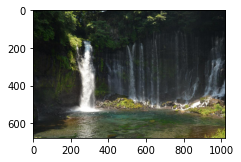

In [ ]:
import numpy as np
from PIL import Image
query_image_pillow=Image.open(f'{IMAGES_PATH}/00000061_(6).jpg')
query_image_features=calculate_descr(query_image_pillow)[1]
show_images([np.array(query_image_pillow)])
print(query_image_features.shape)

In [ ]:
bf = cv2.BFMatcher()
def match_descriptors(IMAGE_SIMILARITIES,filename,matches):
    good_matches = []
    good_matches_sum=0
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good_matches.append(m)
            good_matches_sum+=m.distance
    if len(good_matches)<5:
        return
    bestN=5
    topBestNSum=0
    good_matches.sort(key=lambda match: match.distance)
    for match in good_matches[:bestN]:
        topBestNSum+=match.distance
    IMAGE_SIMILARITIES.append({"id": filename, "distance": (topBestNSum/bestN)*good_matches_sum/(len(good_matches))})

def sift_reverse_search(image_file):
    IMAGE_SIMILARITIES=[]
    _,target_descriptors=calculate_descr(image_file)
    for image in all_image_features:
        matches = bf.knnMatch(target_descriptors,image["descs"], k=2)
        match_descriptors(IMAGE_SIMILARITIES,image["file_name"],matches)
    IMAGE_SIMILARITIES.sort(key=lambda image: image["distance"])
    print(IMAGE_SIMILARITIES[:10])
    return list(map(lambda el: el["id"],IMAGE_SIMILARITIES[:10]))

In [ ]:
%%time
res=sift_reverse_search(query_image_pillow)
print(res)

[{'id': '00000061_(6).jpg', 'distance': 0.0}, {'id': '00000521_(5).jpg', 'distance': 0.048990689043576695}, {'id': '00000640_(3).jpg', 'distance': 0.05595243144672319}, {'id': '00000458_(2).jpg', 'distance': 0.1125695662420981}, {'id': '00000741.jpg', 'distance': 0.11864623909410837}, {'id': '00000737_(2).jpg', 'distance': 0.1400773131339017}, {'id': '00000527_(5).jpg', 'distance': 0.14355220891374815}, {'id': '00000561_(4).jpg', 'distance': 0.14537358082716495}, {'id': '00000278.jpg', 'distance': 0.14952833018801343}, {'id': '00000085_(5).jpg', 'distance': 0.15132712938221232}]
['00000061_(6).jpg', '00000521_(5).jpg', '00000640_(3).jpg', '00000458_(2).jpg', '00000741.jpg', '00000737_(2).jpg', '00000527_(5).jpg', '00000561_(4).jpg', '00000278.jpg', '00000085_(5).jpg']
CPU times: user 54.1 s, sys: 731 ms, total: 54.8 s
Wall time: 27.9 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


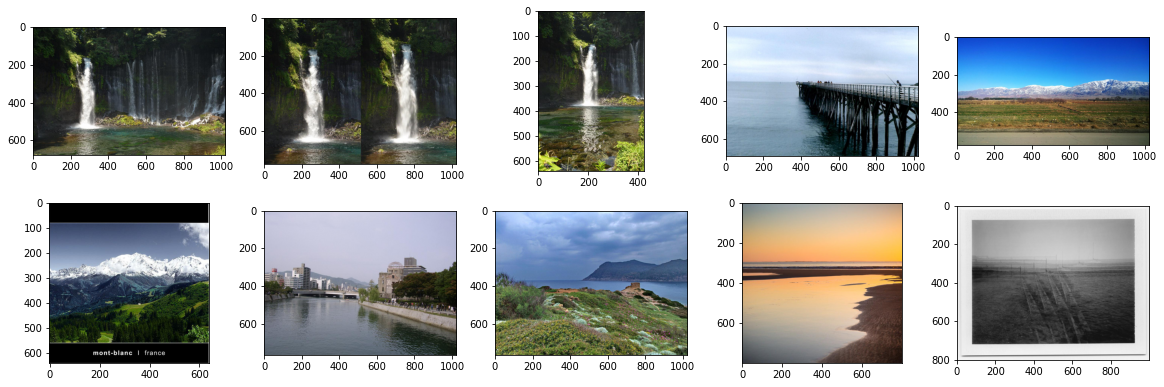

In [ ]:
found_images=[]
for file_name in res:
    found_images.append(np.array(Image.open(IMAGES_PATH+"/"+file_name)))
show_images(np.array(found_images))

[{'id': '00000061_(6).jpg', 'distance': 0.0}, {'id': '00000521_(5).jpg', 'distance': 0.08912852837215485}, {'id': '00000640_(3).jpg', 'distance': 0.09626580459318712}, {'id': '00000164_(3).jpg', 'distance': 0.10467426842649312}, {'id': '00000057_(5).jpg', 'distance': 0.1199692987234654}, {'id': '00000064_(3).jpg', 'distance': 0.12723365507867393}, {'id': '00000238_(6).jpg', 'distance': 0.12774459905424937}, {'id': '00000073_(3).jpg', 'distance': 0.12956802548173185}, {'id': '00000281.jpg', 'distance': 0.13070348835349307}, {'id': '00000662_(2).jpg', 'distance': 0.1344943586945792}]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


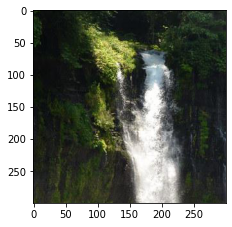

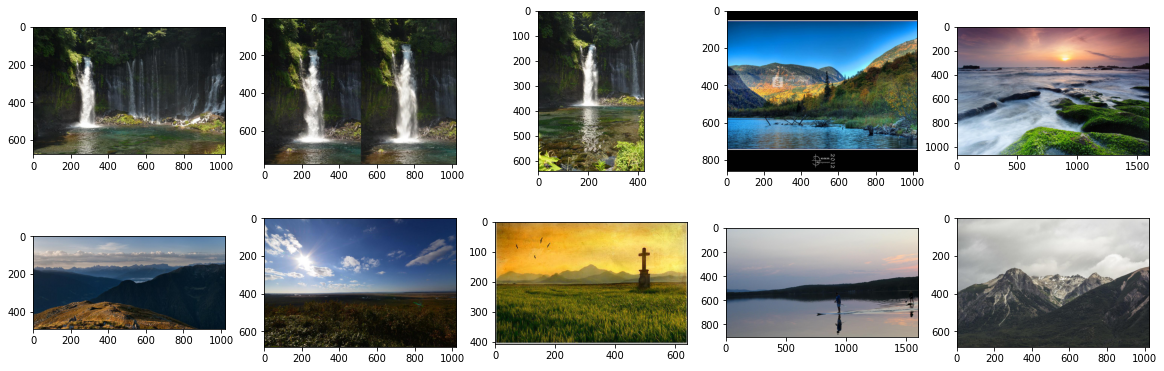

In [12]:
crop_rectangle = (100, 100, 400, 400)
query_image_cropped = query_image_pillow.crop(crop_rectangle)
res2=sift_reverse_search(query_image_cropped)
show_images([np.array(query_image_cropped)])
found_images_2=[]
for file_name in res2:
    found_images_2.append(np.array(Image.open(IMAGES_PATH+"/"+file_name)))
show_images(np.array(found_images_2))